In [63]:
from SimPEG import EM, Mesh, Utils, Maps
from scipy.constants import mu_0
from pymatsolver import MumpsSolver
import cPickle as pickle
from ipywidgets import interact, IntSlider
import warnings
warnings.filterwarnings("ignore")
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 3D ATEM inversion

Use branch: em/ref/tdem to run codes

Python files for Forward and Inversion:
- Forward: https://github.com/simpeg/presentations/blob/ATEM/SciPy2016/notebooks/ATEM/TKCATEMfwd.py
- Inversion: https://github.com/simpeg/presentations/blob/ATEM/SciPy2016/notebooks/ATEM/TKCATEMinv.py

Some TODOs simpeg TDEM codes:

- General Waveform
- Current sources both edge (EB form) and face (HJ form)

## Load pickled information

In [64]:
TKCATEMexample = pickle.load(open( "TKCATEMexample.p", "rb" ))
print TKCATEMexample.keys()

['perc', 'ntx', 'floor', 'dobs_ds', 'xyz', 'xyz_ds', 'times', 'dtrue', 'mesh', 'dobs', 'ntx_ds', 'timeSteps', 'sigma', 'timeSteps_inv']


In [65]:
mesh = TKCATEMexample["mesh"]
print mesh

  ---- 3-D TensorMesh ----  
   x0: -4774.44
   y0: -4704.44
   z0: -4809.44
  nCx: 45
  nCy: 41
  nCz: 50
   hx: 1060.06, 815.43, 627.26, 482.50, 371.16, 285.51, 219.62, 168.94, 129.95, 99.96, 76.89, 59.15, 45.50, 19*35.00, 45.50, 59.15, 76.89, 99.96, 129.95, 168.94, 219.62, 285.51, 371.16, 482.50, 627.26, 815.43, 1060.06
   hy: 1060.06, 815.43, 627.26, 482.50, 371.16, 285.51, 219.62, 168.94, 129.95, 99.96, 76.89, 59.15, 45.50, 15*35.00, 45.50, 59.15, 76.89, 99.96, 129.95, 168.94, 219.62, 285.51, 371.16, 482.50, 627.26, 815.43, 1060.06
   hz: 1060.06, 815.43, 627.26, 482.50, 371.16, 285.51, 219.62, 168.94, 129.95, 99.96, 76.89, 59.15, 45.50, 9*35.00, 6*17.50, 9*35.00, 45.50, 59.15, 76.89, 99.96, 129.95, 168.94, 219.62, 285.51, 371.16, 482.50, 627.26, 815.43, 1060.06


In [66]:
# # Compute Diffusion distance: only works for simpegem1d
# from simpegem1d import EM1DAnal
# print EM1DAnal.DiffusionDistnace(1e-4, 5e-2)
# print EM1DAnal.DiffusionDistnace(2e-3, 1e-4)
# print mesh.hx[:npad].sum()

In [67]:
def gettopoCC(mesh, airind):
# def gettopoCC(mesh, airind):
    """
        Get topography from active indices of mesh.
    """
    mesh2D = Mesh.TensorMesh([mesh.hx, mesh.hy], mesh.x0[:2])
    zc = mesh.gridCC[:,2]
    AIRIND = airind.reshape((mesh.vnC[0]*mesh.vnC[1],mesh.vnC[2]), order='F')
    ZC = zc.reshape((mesh.vnC[0]*mesh.vnC[1], mesh.vnC[2]), order='F')
    topo = np.zeros(ZC.shape[0])
    topoCC = np.zeros(ZC.shape[0])
    for i in range(ZC.shape[0]):
        ind  = np.argmax(ZC[i,:][~AIRIND[i,:]])
        topo[i] = ZC[i,:][~AIRIND[i,:]].max() + mesh.hz[~AIRIND[i,:]][ind]*0.5
        topoCC[i] = ZC[i,:][~AIRIND[i,:]].max()
    XY = Utils.ndgrid(mesh.vectorCCx, mesh.vectorCCy)
    return mesh2D, topoCC
def vizsection(sigma, indy=20):
    figsize(5,2.5)
    # mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True, normal="X")
    mesh.plotSlice(np.log10(sigma), ind=indy, grid=True, normal="Y", clim=(-4, -1), pcolorOpts={"cmap":"viridis"})
    plt.axis("equal")
    plt.title(("Northing at %.1fm")%(mesh.vectorCCy[indy]))
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")    
    xlim(-500, 500)
    ylim(-500, 0)
    
def vizplan(sigma, indz=21):
    figsize(5,5)
    # mesh.plotSlice(np.ones(mesh.nC)*np.nan, grid=True)
    mesh.plotSlice(np.log10(sigma), grid=True, ind=indz, clim=(-4, -1), pcolorOpts={"cmap":"viridis"})
#     plt.plot(xyz[:,0], xyz[:,1], 'r.')
    plt.plot(xyz[::2,0], xyz[::2,1], 'wo', ms=3)
    plt.title(("Elevation at %.1fm")%(mesh.vectorCCz[indz]))
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")
    xlim(-500, 500)
    ylim(-500, 500)

## True $\sigma(x, y, z)$ model, and get topographic information from $\sigma$

In [68]:
sigma = TKCATEMexample["sigma"]
airind = sigma==1e-8
mesh2D, topoCC = gettopoCC(mesh, airind)
sigma_masked = sigma.copy()
sigma_masked[airind] = np.nan

## Design ATEM survey

In [69]:
# Tx-Rx pair locations
nskip = 2
x = mesh.vectorCCx[np.logical_and(mesh.vectorCCx>-300., mesh.vectorCCx<300.)]
y = mesh.vectorCCy[np.logical_and(mesh.vectorCCy>-300., mesh.vectorCCy<300.)][::nskip]
xy = Utils.ndgrid(x, y)
rxinds = Utils.closestPoints(mesh2D, xy)
zlocs = topoCC[rxinds]
xyz = np.c_[xy, zlocs]

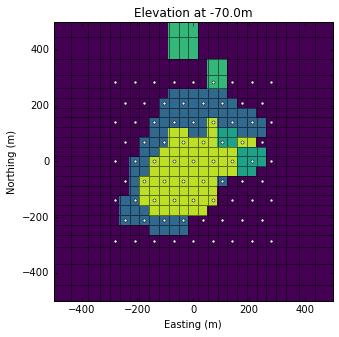

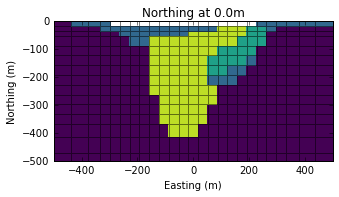

In [70]:
vizplan(sigma_masked)
vizsection(sigma_masked)

In [71]:
ntx = xyz.shape[0]
srcLists = []
times = np.logspace(-4, np.log10(2e-3), 10)
for itx in range(ntx):
    rx = EM.TDEM.Rx(xyz[itx,:], times, 'bz')
    src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=xyz[itx,:], radius = 13.) # same src location as FDEM problem        
    srcLists.append(src)

## Obtain TDEM problem

In [72]:
# TDEM problem
survey = EM.TDEM.Survey(srcLists)    
problem = EM.TDEM.Problem_b(mesh, verbose=True)
timeSteps_fwd = [(1e-5, 5), (1e-4, 10),(5e-4, 10)]
timeSteps_inv = [(1e-5, 5), (1e-4, 10),(5e-4, 3)]
problem.timeSteps = timeSteps_inv
problem.pair(survey)
problem.Solver = MumpsSolver
# run FWD
# survey.dpred(sigma)

In [73]:
ntime = times.size
DTRUE = TKCATEMexample["dtrue"].reshape((ntime, ntx), order="F")*1e9
DOBS = TKCATEMexample["dobs"].reshape((ntime, ntx), order="F")*1e9
dobs_ds = Utils.mkvc(DOBS[:,::2])/1e9
ntx_ds = DOBS[:,::2].shape[1]

In [80]:
DOBS[0,:].shape

(153,)

In [74]:
## Assign noise 
# dpred = TKCATEMexample_fwd["dpred"]
# perc, floor = 0.05, 2e-16
# noise = 0.05*abs(dpred)*np.random.randn(dpred.size) + np.ones_like(dpred)*np.random.randn(dpred.size)*floor
# dobs = dpred + noise
## Save 
# TKCATEMexample = {"mesh": mesh, "sigma":sigma, "xyz":xyz, "ntx":ntx,
#                   "times":times, "timeSteps":problem.timeSteps,"timeSteps_inv": timeSteps_inv,
#                   "dtrue":dpred, "dobs":dobs, "perc": 0.05, "floor":floor, 
#                   "xyz_ds":xyz[::2,:], "dobs_ds":dobs_ds, "ntx_ds":ntx_ds}
# pickle.dump( TKCATEMexample, open( "TKCATEMexample.p", "wb" ) )

## Visualize ATEM data 

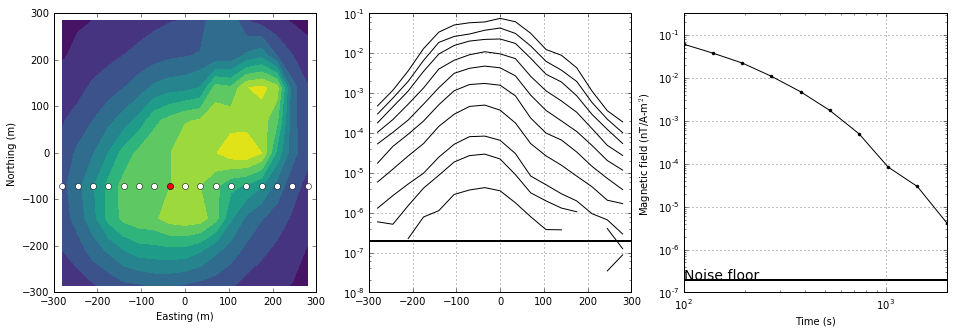

<function __main__.viz>

In [96]:
nx, ny = x.size, y.size
nT = 1e9  #nano Tesla
mus = 1e6 #micro-s
def viz(itime, irx, iy):
    fig = plt.figure(figsize=(16,5))
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)
    D = DOBS[:,:].reshape((ntime, nx, ny), order="F")
    ax1.contourf(xy[:,0].reshape((nx, ny), order="F"), xy[:,1].reshape((nx, ny), order="F"), np.log10(DOBS[itime,:].reshape((nx, ny), order="F")), 10, cmap="viridis")
    ax1.plot(x, np.ones_like(x)*y[iy], "wo")    
    ax1.plot(xyz[irx,0], xyz[irx,1], "ro")    
    ax1.set_xlim(-300, 300)
    ax1.set_ylim(-300, 300)
    ax1.set_xlabel("Easting (m)")
    ax1.set_ylabel("Northing (m)")
    ax3.loglog(times*mus, DOBS[:,irx], 'k.-')
    ax3.text(1e2, TKCATEMexample["floor"]*nT, "Noise floor", fontsize = 14)
    ax3.loglog(times*mus, np.ones_like(times)*TKCATEMexample["floor"]*nT, 'k-', lw=2)
    ax3.set_xlim(times.min()*mus, times.max()*mus)
    ax3.set_ylim(1e-7, DOBS.flatten().max()); ax3.grid(True)
    ax3.set_xlabel("Time (s)")
    ax3.set_ylabel("Magnetic field (nT/A-m$^2$)") 
    ax2.semilogy(np.r_[-300, 300], np.ones(2)*TKCATEMexample["floor"]*nT, 'k-', lw=2)
    ax2.grid(True)
    for itime in range (ntime):
        ax2.semilogy(x, D[itime, :,iy], 'k')
    plt.show()
interact(viz, itime=IntSlider(min=0, max=9,step=1, value=0), 
              irx=IntSlider(min=0, max=ntx-1,step=1, value=58),
              iy=IntSlider(min=0, max=ny-1,step=1, value=3))    

## Load inversion results

In [97]:
predmodel = []
for i in range(1,11):
    if i<10:
        temp = np.load("./invresults/00"+str(i)+"-InversionModel-2016-06-28-20-00.npy")
    else:
        temp = np.load("./invresults/0"+str(i)+"-InversionModel-2016-06-28-20-00.npy")
    predmodel.append(temp)

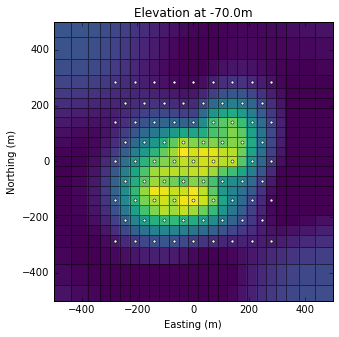

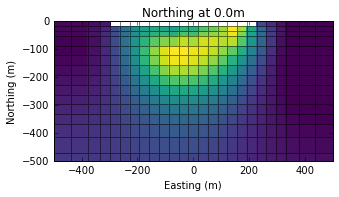

In [98]:
iteration = 9
airind = sigma == 1e-8
expmap = Maps.ExpMap(mesh)
actmap = Maps.InjectActiveCells(mesh, ~airind, np.log(1e-8))
mapping = expmap*actmap
sigest = mapping*predmodel[iteration]
sigest[airind] = np.nan
vizplan(sigest)
vizsection(sigest)